# Derive EOMs of Pendulum


In [74]:
# %reset
# import libraries
import sympy as sym
import numpy as np
sym.init_printing()
from IPython.display import display #for pretty printing

# system parameters
X0,Y0 = sym.symbols(['X0','Y0']) # fixed position of the pendulum
g = sym.symbols('g')
mp = sym.symbols('m') # mass of pendulum 
L = sym.symbols('L') # length of pendulum
In = sym.symbols('I_{p}') # moment of intertia of pendulum

# generalized coordinates
th = sym.symbols('theta') #position
dth = sym.symbols('\dot{\\theta}') #velocity
ddth = sym.symbols('\ddot{\\theta}') #acceleration

q = sym.Matrix([th]) #group into matrices
dq = sym.Matrix([[dth]])
ddq = sym.Matrix([ddth])

# total joint action
tau = sym.symbols('\\tau')

# STEP 1: position vectors
r = sym.Matrix([[X0-L/2*sym.sin(th)],
                [Y0+L/2*sym.cos(th)],
                [th]])

# the Jacobian
J = r.jacobian(q)

# STEP 2: generate expressions for the system space velocities from the jacobians
v = J*dq

# STEP 3: generate expressions for the kinetic and potential energy
# mass vectors
M = sym.Matrix([[mp,mp,In]])

T = 0.5*M*sym.matrix_multiply_elementwise(v,v)
T = T[0]
V = mp*g*r[1]

# STEP 4: calculate each term of the Lagrange equation
# term 1
Lg1 = sym.zeros(len(q),1)
for i in range(len(q)):
    dT_ddq = sym.Matrix([sym.diff(T,dq[i])]) # get partial of T in dq_i
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq #...then get time derivative of that partial

# term 3
Lg3 = sym.Matrix([T]).jacobian(q).transpose() # partial of T in q

# term 4
Lg4 = sym.Matrix([V]).jacobian(q).transpose() # partial of U in q

# STEP 5: generalized forces

# Torque
tau_p = sym.Matrix([[0],[0],[tau]])

Q = sym.zeros(len(q),1)
for j in range(len(q)):
    Q[j] = tau_p.transpose()*J[:,j]

# AND combine!
EOM = Lg1 - Lg3 + Lg4 - Q

EOMs = sym.zeros(len(q),1)
for j in range(len(q)):
    EOMs[j] = EOM[j].simplify()

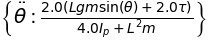

In [75]:
sym.solve(EOMs, ddq)

In [76]:
import pickle as pkl

data = {"EOMs":EOMs}

outfile = open('pendulum_EOMs','wb')
pkl.dump(data,outfile)
outfile.close()

In [77]:
#initial conditions

h = 0.01

#parameters
X0val = 0.0
Y0val = 0.0
thval = 0.3
dth0 = 0.0
mval = 5.0
Lval = 1.0
Inval = 1/12*mval*Lval**2
tauval = 0.0

parameter_values = [(g,9.81),(m,mval),(tau,tauval),(X0,X0val),(Y0,Y0val),(L, Lval),(In, Inval)]

thar = [thval]
dthar = [dth0]
# tauar = []

N = 100
for i in range(1,N):
    # substitute parameter values and previous conditions into the EOM 
    past = [(th,thar[i-1]),(dth,dthar[i-1])]
    EOM_sub = EOMs.subs(parameter_values).subs(past)
    
    # solve for the acceleration
    acc = sym.solve(EOM_sub,[ddth])
    
    # integrate for the next velocity and position    
    dthar.append(float(dthar[i-1]+h*acc[ddth]))
    thar.append(float(thar[i-1]+h*dthar[i]))

In [78]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

def plot_pendulum(i,th_in,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
#     ax.grid()
    
    #plot pendulum
    topx = X0val
    topy = Y0val
    botx = X0val - Lval/2*np.sin(th_in[i])
    boty = Y0val + Lval/2*np.cos(th_in[i])
    ax.plot([topx, botx],[topy, boty])
    
update = lambda i: plot_pendulum(i,thar,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(N),interval = 50,repeat=True)
plt.close(animate._fig)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


In [79]:
infile = open('pendulum_EOMs','rb')
data = pkl.load(infile)
infile.close()

EOMs = data['EOMs']

EOMs

⎡  L⋅g⋅m⋅sin(θ)                 ⎛                  2  ⎞       ⎤
⎢- ──────────── + \ddot{\theta}⋅⎝1.0⋅I_{p} + 0.25⋅L ⋅m⎠ - \tau⎥
⎣       2                                                     ⎦